# Amazon Helpfulness Predictor

The bulk of the data science for the TrustExpress project was performed in this notebook.

Amazon reviews were loaded into a SQL database and the reviews with greater than 5 helpfulness votes were extracted and made into a pandas dataframe. These reviews were pre-processed, tokenized, and used to train a logistic regression that predicts helpfulness. The tokenizer and classifier were applied to a set of ~100,000 reviews from AliExpress and the results were explored.

## Load in Amazon reviews

Amazon reviews came from http://jmcauley.ucsd.edu/data/amazon/links.html

Image-based recommendations on styles and substitutes
J. McAuley, C. Targett, J. Shi, A. van den Hengel
SIGIR, 2015

Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering
R. He, J. McAuley
WWW, 2016

In [3]:
import pandas as pd
import gzip

import matplotlib.pyplot as plt

import numpy as np

#For working with SQL in Python
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from psycopg2.extensions import AsIs

from imblearn.over_sampling import SMOTE

#For working with XG Boost
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [4]:
#Make a Database
# Define a database name (we're using a dataset on reviews, so we'll call it reviews_db)
# Set your postgres username
dbname = 'amazon_reviews_table'
username = 'rebeccareitz' # change this to your username

## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

postgres://rebeccareitz@localhost/amazon_reviews_table
True


In [5]:
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)
cursor = con.cursor()

In [7]:
#make a table
name_Table = 'all_amazon_reviews'
sqlCreateTable = "create table "+name_Table+"(reviewerID text, asin text, reviewerName text, helpful text, reviewText text, overall float, summary text, unixReviewTime bigint, reviewTime Date, helping int, votes int);"
cursor.execute(sqlCreateTable)

In [8]:
#define functions to add data from zipped json-like amazon reviews into database

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    d = eval(l)
    helpful = d['helpful']
    d['helping']=helpful[0]
    d['votes']=helpful[1]
    yield d
    

def insert_to_table(path):
  for d in parse(path):
    columns = d.keys()
    values = [d[column] for column in columns]
    insert_statement = 'insert into all_amazon_reviews (%s) values %s'
    cursor.execute(insert_statement, (AsIs(','.join(columns)), tuple(values)))

In [9]:
insert_to_table('Amazon_Reviews/reviews_Pet_Supplies_5.json.gz')

In [10]:
insert_to_table('Amazon_Reviews/reviews_Cell_Phones_and_Accessories_5.json.gz')

In [11]:
insert_to_table('Amazon_Reviews/reviews_Home_and_Kitchen_5.json.gz')

In [12]:
insert_to_table('Amazon_Reviews/reviews_Office_Products_5.json.gz')

In [13]:
insert_to_table('Amazon_Reviews/reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

In [14]:
# query:
sql_query = """
SELECT reviewtext, helping, votes FROM all_amazon_reviews;
"""
review_data_from_sql = pd.read_sql_query(sql_query,con)
review_data_from_sql.head()

,reviewtext,helping,votes
0,I purchased the Trilogy with hoping my two cat...,0,0
1,There are usually one or more of my cats watch...,0,0
2,I bought the triliogy and have tested out all ...,0,0
3,My female kitty could care less about these vi...,2,2
4,"If I had gotten just volume two, I would have ...",6,7


In [15]:
review_data_from_sql.shape

(1235892, 3)

In [16]:
review_data_from_sql.to_csv('Amazon_Reviews/amazon_reviews_text_helping_votes.csv')

In [17]:
df_voted_all = review_data_from_sql

## Pre-process the reviews

With the reviews now loaded into a pandas dataframe (and saved to a csv file, just in case), they can now be explored and pre-processed.

In [26]:
df_voted_all = pd.read_csv('Amazon_Reviews/amazon_reviews_text_helping_votes.csv',index_col=0, low_memory=False)

In [27]:
df_voted_all['helpful_frac'] = df_voted_all['helping']/df_voted_all['votes']

In [18]:
df_voted_all.head()

,reviewtext,helping,votes
0,I purchased the Trilogy with hoping my two cat...,0,0
1,There are usually one or more of my cats watch...,0,0
2,I bought the triliogy and have tested out all ...,0,0
3,My female kitty could care less about these vi...,2,2
4,"If I had gotten just volume two, I would have ...",6,7


(array([1.235818e+06, 5.900000e+01, 6.000000e+00, 3.000000e+00,
        3.000000e+00, 2.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([    0.  ,  1043.52,  2087.04,  3130.56,  4174.08,  5217.6 ,
         6261.12,  7304.64,  8348.16,  9391.68, 10435.2 , 11478.72,
        12522.24, 13565.76, 14609.28, 15652.8 , 16696.32, 

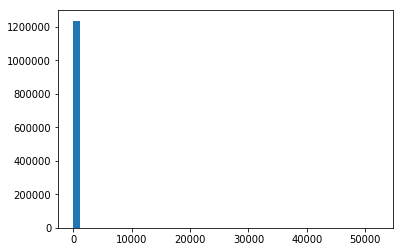

In [20]:
%matplotlib inline

plt.hist(df_voted_all['helping'],bins=50)

The classes are going to be substantially unbalanced. Most people who bother marking a review as helpful or unhelpful are doing so because they found the review helpful.

In [22]:
df_unhelp = df_voted_all.loc[df_voted_all['helping']<5]

In [21]:
df_help = df_voted_all.loc[df_voted_all['helping']>5]
df_help.shape

(79393, 3)

In [23]:
df_unhelp.shape

(1141284, 3)

In [67]:
df_help_downsample = df_help.sample(n=df_unhelp.shape[0])

One option would be to downsample the majority class. But this would likely limit the generalizablility of the model.

In [68]:
df_help_downsample.shape

(8740, 12)

In [24]:
df_help['label']=True

/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_unhelp['label']=False

/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
df_unhelp.head()

,reviewtext,helping,votes,label
0,I purchased the Trilogy with hoping my two cat...,0,0,False
1,There are usually one or more of my cats watch...,0,0,False
2,I bought the triliogy and have tested out all ...,0,0,False
3,My female kitty could care less about these vi...,2,2,False
6,My puppy loves this stuff! His tail starts wag...,2,2,False


In [27]:
df_together = pd.concat([df_unhelp[:], df_help[:]], axis=0)
df_together.shape

(1220677, 4)

In [72]:
df_resampled = pd.concat([df_unhelp[:], df_help_downsample[:]], axis=0)

In [73]:
df_resampled.shape

(17480, 13)

In [31]:
df_together['reviewtext']= df_together.reviewtext.apply(str)

In [30]:
df_together.columns

Index(['reviewtext', 'helping', 'votes', 'label'], dtype='object')

Special characters were removed, and the text data was explored

In [32]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [33]:
standardized_df = standardize_text(df_together, 'reviewtext')

In [18]:
#Tokenize the text - old method
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

standardized_df["tokens"] = standardized_df['reviewText'].apply(tokenizer.tokenize)
standardized_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helping,votes,helpful_frac,label,tokens
147,AOC6CQ1MHA8UD,B000051SEP,P. Taegel,"[3, 6]","this watch screams high tech, and anyone ventu...",5.0,Excellent Watch,1121472000,"07 16, 2005",3,6,0.500000,False,"[this, watch, screams, high, tech, and, anyone..."
323,A2182PKLBKXADO,B00006XXGO,xmx,"[1, 6]",my son only wore these shoes once (he's only 2...,2.0,Wait until they're older,1335139200,"04 23, 2012",1,6,0.166667,False,"[my, son, only, wore, these, shoes, once, he, ..."
338,A1PPDBGCKM9AM0,B0000722HK,"Skipper McFearson ""quickcuda6""","[6, 15]",great fabric and tight fit problem is that i...,1.0,Designed for dwarfs,1298592000,"02 25, 2011",6,15,0.400000,False,"[great, fabric, and, tight, fit, problem, is, ..."
374,A2CDDKORD3XRBJ,B000072UMJ,el viejo,"[0, 10]",i did not know that converse stooped that low ...,1.0,VIETNAM GARBAGE,1360281600,"02 8, 2013",0,10,0.000000,False,"[i, did, not, know, that, converse, stooped, t..."
729,AYOMAHLWRQHUG,B0000868O9,Conspicuous Consumer,"[4, 7]",i was looking for a casual bra to wear when i ...,1.0,Neither Comfortable Nor Attractive,1277942400,"07 1, 2010",4,7,0.571429,False,"[i, was, looking, for, a, casual, bra, to, wea..."


In [64]:
standardized_df['reviewText'].dtype

dtype('O')

In [54]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rebeccareitz/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [55]:
import random
import codecs
from collections import defaultdict
from gensim.models.ldamodel import LdaModel as Lda
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk import pos_tag
import enchant
spelling_dict = enchant.Dict("en_US")
stop = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()
stemmed_dict = defaultdict(set)
def stem_and_update_stem_dict(tokens):
    output_list = []
    for token in tokens:
        stemmed = stemmer.stem(token)
        if stemmed != token:
            stemmed_dict[stemmed].add(token)
        output_list.append(stemmed)
    return output_list

list_of_POS_to_ignore = ['WRB', 'WP$', 'WP',  'WDT', 'UH', 
                         'TO', 'RP', 'RBS', 'RBR', 'PRP$', 'PRP', 
                        'MD', 'JJS', 'JJR', 'JJ', 'IN', 'FW', 'EX', 
                         'DT', 'CD']

In [58]:
def clean(tokens): 
    tokens = [i for i in tokens if i not in stop]
    # removing pos data 
    tokens = [word for word, pos in pos_tag(tokens) if pos not in list_of_POS_to_ignore]
    # Removing improperly spelled words (pronouns must be capitalized to be spelled right)
    tokens = [word for word in tokens if spelling_dict.check(word)]
    # lowercase
    tokens = [word.lower() for word in tokens]
    # lemmatized
    tokens = [lemma.lemmatize(word, 'v') for word in tokens]
    # removing short words 
    tokens = [s for s in tokens if len(s) > 2]
    # stemmed
    tokens = stem_and_update_stem_dict(tokens)
    return tokens

In [70]:
standardized_df["tokens"] = clean(standardized_df['tokens'])

TypeError: expected string or bytes-like object

In [78]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in standardized_df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in standardized_df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

3112015 words total, with a vocabulary size of 45698
Max sentence length is 3536


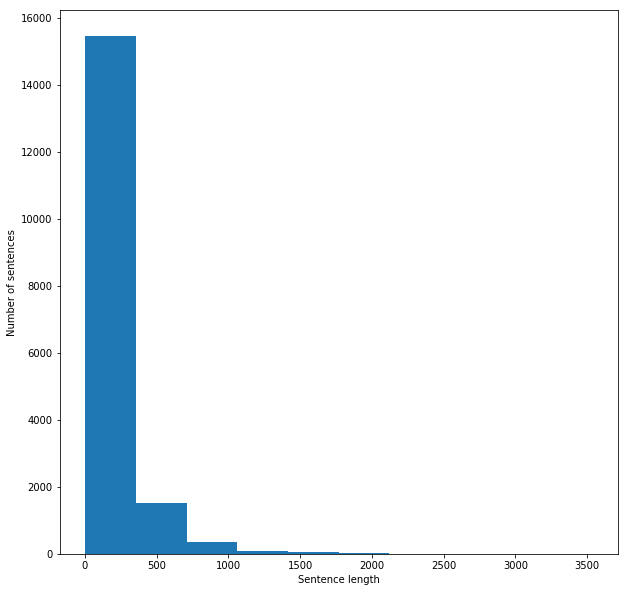

In [79]:
#most reviews are short
import matplotlib.pyplot as plt

%matplotlib inline
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

## The Heart of the Thing

The reviews are split into test and training sets and tokenized. The minority class in the training set is upsampled and models are trained and tested.

In [36]:
from sklearn.model_selection import train_test_split

list_corpus = standardized_df["reviewtext"].tolist()
list_labels = standardized_df["label"].tolist()

X_train_cv, X_test, y_train_cv, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
X_train, X_cv, y_train, y_cv = train_test_split(X_train_cv, y_train_cv, test_size=0.2, random_state=40)

In [89]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer(stop_words = 'english')

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

X_train_counts, count_vectorizer = cv(X_train)
X_cv_counts = count_vectorizer.transform(X_cv)

In [112]:
X_test_counts = count_vectorizer.transform(X_test)

In [22]:
sm = SMOTE(random_state=12, ratio = 1.0) #smote is used to upsample the unhelpful reviews

In [24]:
X_train_rs, y_train_rs = sm.fit_sample(X_train_counts, y_train)

/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


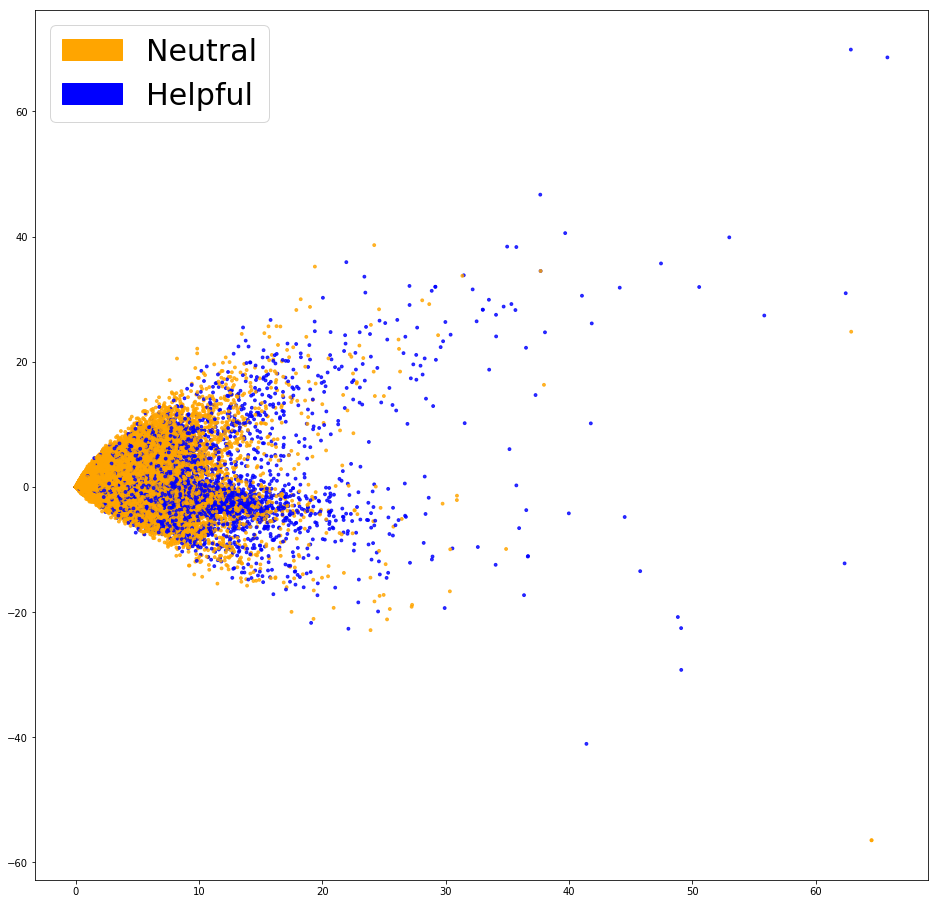

In [110]:
from  sklearn.decomposition  import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Neutral')
            green_patch = mpatches.Patch(color='blue', label='Helpful')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

%matplotlib inline
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

#LSA plot of the bag-of-words reviews looks poorly separable

In [39]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', n_jobs=-1)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_cv_counts)

/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [90]:
from sklearn.linear_model import SGDClassifier

clf_SGD = SGDClassifier(loss="log", penalty="l2", class_weight = 'balanced')
clf_SGD.fit(X_train_counts, y_train)

y_predicted_counts = clf_SGD.predict(X_cv_counts)

/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [71]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_cv, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.779, precision = 0.915, recall = 0.779, f1 = 0.831


In [72]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf_SGD, 10)

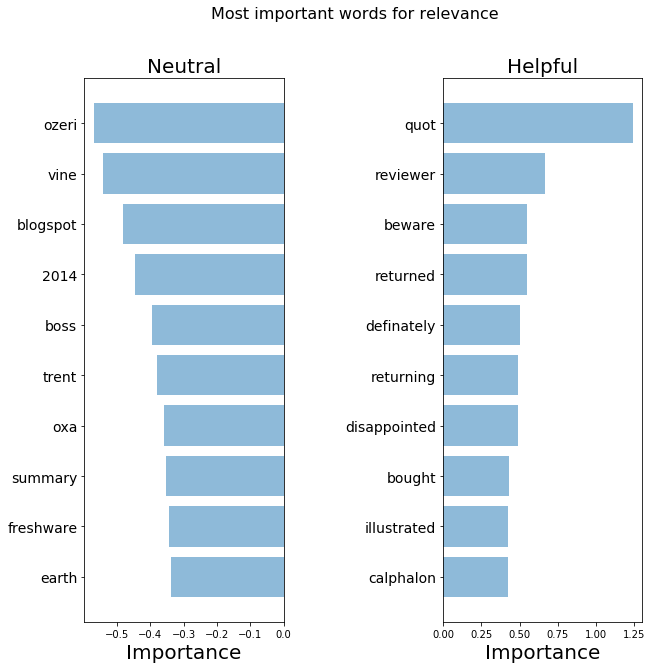

In [156]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Neutral', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Helpful', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

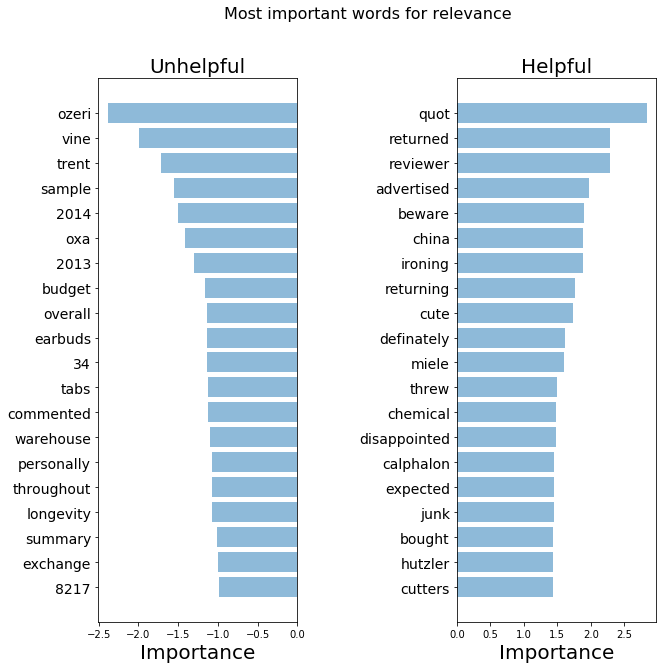

In [74]:
importance = get_most_important_features(count_vectorizer, clf_SGD, 20)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [ ]:
#tune parameters
from time import time
from operator import itemgetter

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}\n".format(score.parameters))
    return 

In [75]:
# use a full grid over all parameters
param_grid = {"max_iter": [3, 5, 10],
              "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "penalty": ["l1", "l2"]}
 
# run grid search
grid_search = GridSearchCV(clf_SGD, param_grid=param_grid)
start = time()
grid_search.fit(X_train_counts, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings." % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 1003.77 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.935 (std: 0.000)
Parameters: {'alpha': 10, 'max_iter': 3, 'penalty': 'l1'}

Model with rank: 2
Mean validation score: 0.935 (std: 0.000)
Parameters: {'alpha': 10, 'max_iter': 5, 'penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.935 (std: 0.000)
Parameters: {'alpha': 100, 'max_iter': 3, 'penalty': 'l1'}



/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [107]:
#
clf_SGD = SGDClassifier(loss="log", penalty="l2", max_iter = 5)
clf_SGD.fit(X_train_counts, y_train)

y_predicted_counts = clf_SGD.predict(X_cv_counts)

In [108]:
accuracy, precision, recall, f1 = get_metrics(y_cv, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.931, precision = 0.909, recall = 0.931, f1 = 0.916


In [154]:
y_predicted_test = clf_SGD.predict(X_test_counts)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_test)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.930, precision = 0.908, recall = 0.930, f1 = 0.915


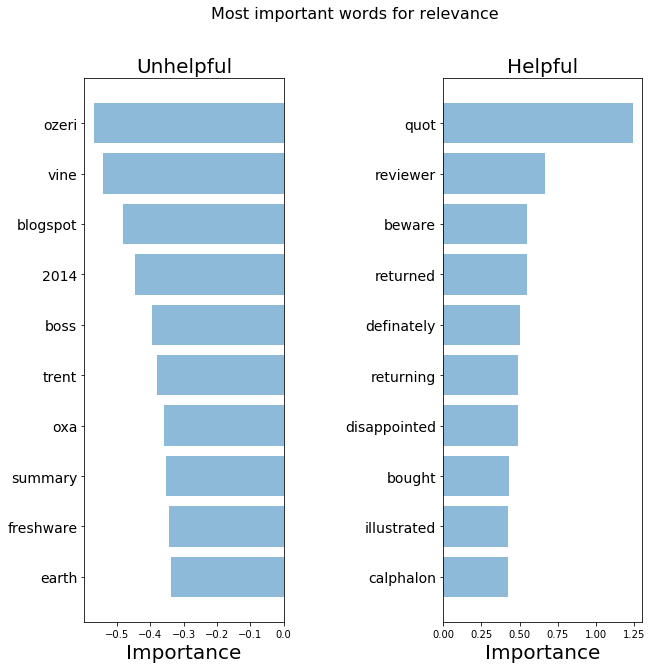

In [155]:
importance = get_most_important_features(count_vectorizer, clf_SGD, 10)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [52]:
#Get TFIDF vectors for data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_cv_tfidf = tfidf_vectorizer.transform(X_cv)

In [30]:
X_train_tfidf_rs, y_train_rs = sm.fit_sample(X_train_tfidf, y_train)

/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


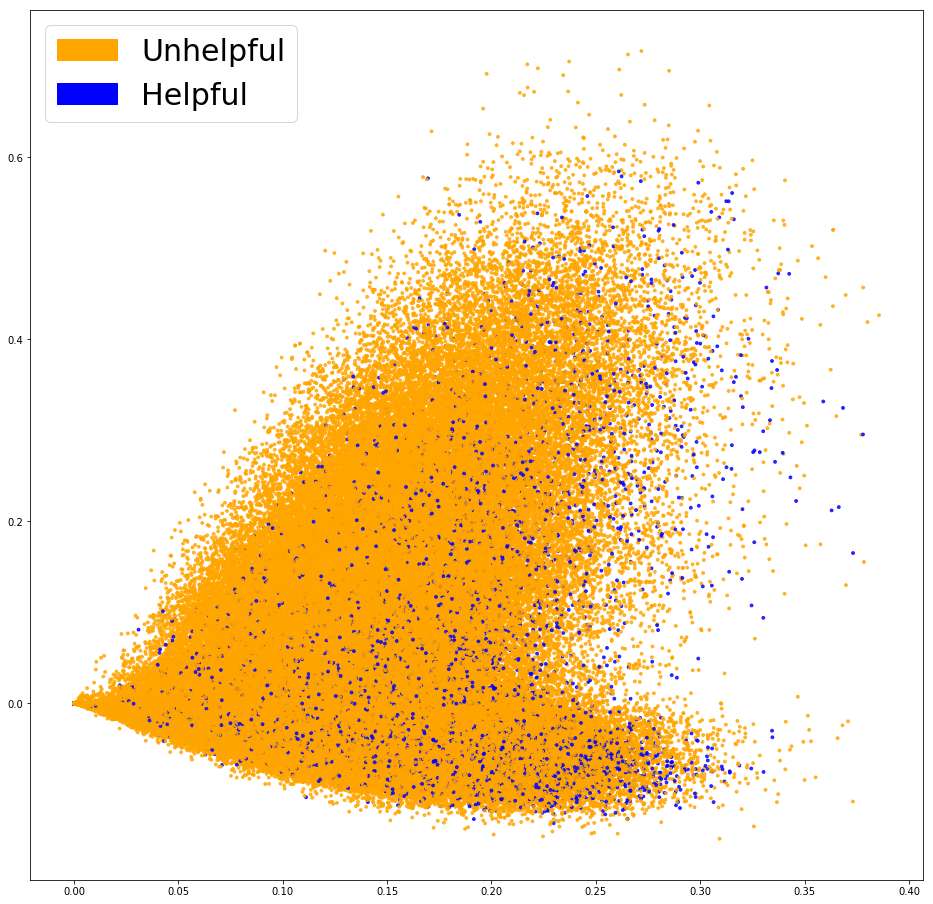

In [48]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [32]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf_rs, y_train_rs)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [103]:
clf_SGD_tfidf = SGDClassifier(loss="log", penalty="l2", max_iter=5, class_weight='balanced')
clf_SGD_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = clf_SGD_tfidf.predict(X_cv_tfidf)

In [95]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_cv, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.741, precision = 0.919, recall = 0.741, f1 = 0.805


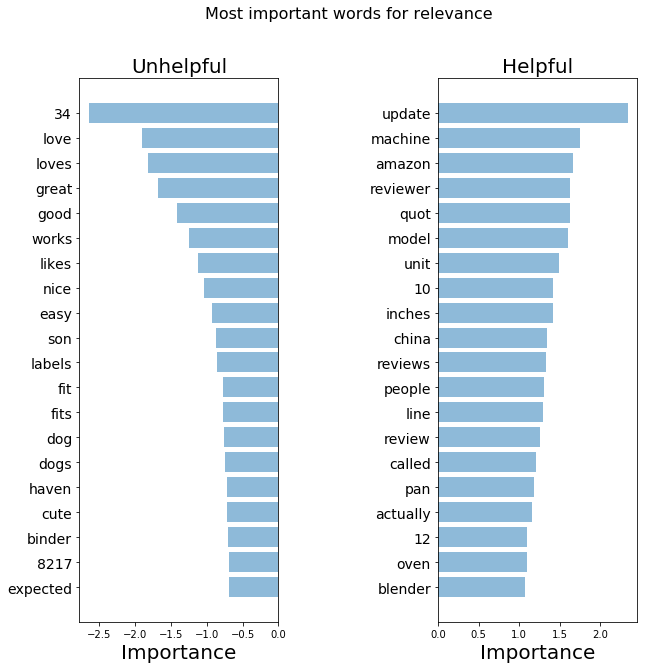

In [96]:
importance = get_most_important_features(tfidf_vectorizer, clf_SGD_tfidf, 20)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [67]:
#tune parameters
from time import time
from operator import itemgetter

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}\n".format(score.parameters))
    return 

In [104]:
# use a full grid over all parameters
param_grid = {"alpha": [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.01, 0.1, 1, 10, 100],
              "penalty": ["l1", "l2"]}
 
# run grid search
grid_search = GridSearchCV(clf_SGD_tfidf, param_grid=param_grid)
start = time()
grid_search.fit(X_train_tfidf, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings." % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)


GridSearchCV took 221.74 seconds for 20 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.935 (std: 0.000)
Parameters: {'alpha': 10, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.935 (std: 0.000)
Parameters: {'alpha': 100, 'penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.763 (std: 0.008)
Parameters: {'alpha': 1e-05, 'penalty': 'l2'}



/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [105]:
clf_SGD_tfidf = SGDClassifier(loss="log", penalty="l2", max_iter=10, alpha=10, class_weight='balanced')
clf_SGD_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = clf_SGD_tfidf.predict(X_cv_tfidf)
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_cv, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))


accuracy = 0.064, precision = 0.004, recall = 0.064, f1 = 0.008


/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


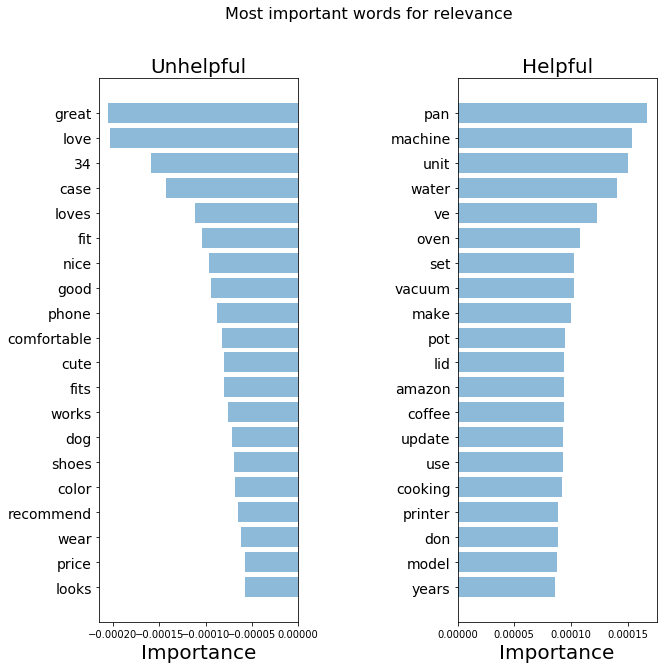

In [106]:
importance = get_most_important_features(tfidf_vectorizer, clf_SGD_tfidf, 20)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [73]:
clf_rand_forest_tfidf = RandomForestClassifier(n_estimators = 40)
clf_rand_forest_tfidf.fit(X_train_tfidf, y_train)
y_predicted_forest_tfidf = clf_rand_forest_tfidf.predict(X_test_tfidf)

NameError: name 'RandomForestClassifier' is not defined

In [74]:
accuracy_forest_tfidf, precision_forest_tfidf, recall_forest_tfidf, f1_forest_tfidf = get_metrics(y_test, y_predicted_forest_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_forest_tfidf, precision_forest_tfidf, 
                                                                       recall_forest_tfidf, f1_forest_word2vec))

NameError: name 'y_predicted_forest_tfidf' is not defined

In [32]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [33]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [88]:
embeddings = get_word2vec_embeddings(word2vec, standardized_df)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

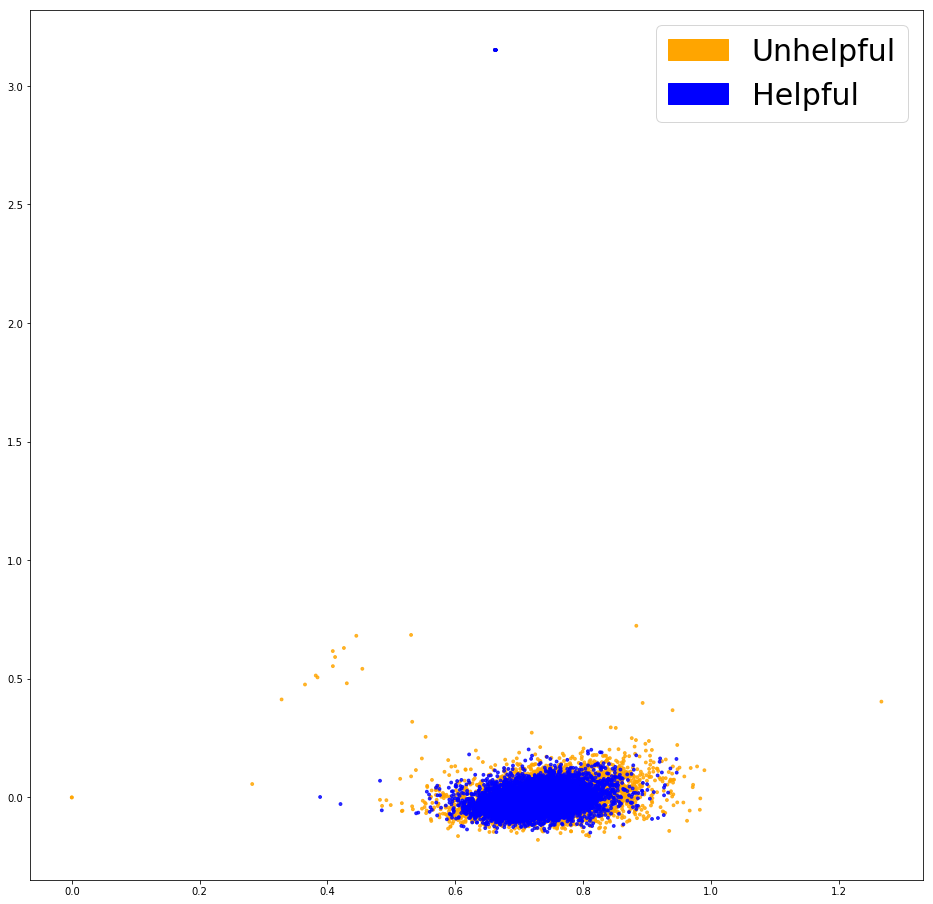

In [89]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

In [90]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [91]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.712, precision = 0.712, recall = 0.712, f1 = 0.712


In [38]:
from sklearn.ensemble import RandomForestClassifier

/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [39]:
clf_rand_forest_w2v = RandomForestClassifier(n_estimators = 40)
clf_rand_forest_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_forest_word2vec = clf_rand_forest_w2v.predict(X_test_word2vec)

In [40]:
accuracy_forest_word2vec, precision_forest_word2vec, recall_forest_word2vec, f1_forest_word2vec = get_metrics(y_test_word2vec, y_predicted_forest_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.657, precision = 0.657, recall = 0.657, f1 = 0.657


The most sucessful technique with a logistic regression with tfidf. Let's pickle the vectorizer and model in case they are needed in the future (aka in case I can get the website to process live data)

In [113]:
import pickle

pickle.dump(count_vectorizer, open("count_vectorizer.pickle", "wb"))
pickle.dump(clf_SGD, open('clf_SGD.pickle', 'wb'))

## Apply Helpfulness to Ali Express Reviews
Load in English AliExpress Reviews - apply prior tfidf encoder - get helpfulness scores using logistic regression model

In [114]:
ali_english_df = pd.read_csv('english_reviews_only.csv',index_col=0,low_memory=False)

In [115]:
ali_english_df.head()

,product_id,anonymous,buyercountry,buyereval,buyerfeedback,buyergender,buyerheadportrait,buyerid,buyername,evaldate,...,max_freq,initial_trust,trust_tag,feedback_na,image_na,feedbacklength,basic_trust,basic_trust_tag,reviewer_review_count,feedback_lang
0,32243608596,False,US,100,"Great fabric and quality, fast delivery and co...",NaN,https://ae01.alicdn.com/kf/UTB8vTH0hFPJXKJkSah...,230419691,E***e L.,2018-08-31,...,1.0,0.5,No standout reviewer features,False,False,81,0.5,Review has no standout features,2.0,en
4,32243608596,False,US,100,thanks!,F,https://ae01.alicdn.com/kf/UTB8eeCYxqrFXKJk43O...,890393619,E****************r N.,2018-08-18,...,1.0,0.5,No standout reviewer features,False,False,7,0.5,Review has no standout features,1.0,en
5,32243608596,False,US,60,not bad for such price,NaN,NaN,1693179945,Y*******d Y.,2018-08-28,...,1.0,0.5,No standout reviewer features,False,False,22,0.5,Review has no standout features,1.0,en
7,32243608596,False,US,100,"nice cap, my boyfriend is very happy with it. ...",NaN,NaN,1673192723,S*****a W.,2018-08-23,...,1.0,1.0,Posts a good number of reviews at a reasonable...,False,True,146,1.0,Trusted Reviewer,1.0,en
11,32243608596,False,US,20,All stained. Terrible goods,M,https://gw.alicdn.com/tps/TB1CjX4LXXXXXbSXFXXX...,725446934,S***g C.,2018-08-29,...,1.0,1.0,Posts a good number of reviews at a reasonable...,False,False,27,1.0,Trusted Reviewer,1.0,en


In [116]:
ali_english_df_stand = standardize_text(ali_english_df,'buyerfeedback')

In [117]:
ali_only_words = ali_english_df_stand['buyerfeedback']

In [118]:
ali_count = count_vectorizer.transform(ali_only_words)

In [119]:
ali_count.shape

(25006, 209261)

In [120]:
ali_y_count = clf_SGD.predict_proba(ali_count)

In [121]:
ali_y_count

array([[0.98294709, 0.01705291],
       [0.99427907, 0.00572093],
       [0.99457007, 0.00542993],
       ...,
       [0.99133671, 0.00866329],
       [0.99253279, 0.00746721],
       [0.99147107, 0.00852893]])

In [123]:
ali_y_count_total = clf_SGD.predict(ali_count)

In [124]:
ali_y_count_total

array([False, False, False, ..., False, False, False])

In [125]:
ali_y_df = pd.DataFrame(ali_y_count, columns = ['unhelp_prob','help_prob'], index = ali_english_df.index.values)

In [126]:
ali_y_df.head()

,unhelp_prob,help_prob
0,0.982947,0.017053
4,0.994279,0.005721
5,0.994570,0.005430
7,0.983816,0.016184
11,0.994508,0.005492


In [127]:
ali_with_amazon_prob = pd.concat([ali_english_df[:],ali_y_df[:]],axis = 1)

In [128]:
ali_with_amazon_prob.head()

,product_id,anonymous,buyercountry,buyereval,buyerfeedback,buyergender,buyerheadportrait,buyerid,buyername,evaldate,...,trust_tag,feedback_na,image_na,feedbacklength,basic_trust,basic_trust_tag,reviewer_review_count,feedback_lang,unhelp_prob,help_prob
0,32243608596,False,US,100,"great fabric and quality, fast delivery and co...",NaN,https://ae01.alicdn.com/kf/UTB8vTH0hFPJXKJkSah...,230419691,E***e L.,2018-08-31,...,No standout reviewer features,False,False,81,0.5,Review has no standout features,2.0,en,0.982947,0.017053
4,32243608596,False,US,100,thanks!,F,https://ae01.alicdn.com/kf/UTB8eeCYxqrFXKJk43O...,890393619,E****************r N.,2018-08-18,...,No standout reviewer features,False,False,7,0.5,Review has no standout features,1.0,en,0.994279,0.005721
5,32243608596,False,US,60,not bad for such price,NaN,NaN,1693179945,Y*******d Y.,2018-08-28,...,No standout reviewer features,False,False,22,0.5,Review has no standout features,1.0,en,0.994570,0.005430
7,32243608596,False,US,100,"nice cap, my boyfriend is very happy with it ...",NaN,NaN,1673192723,S*****a W.,2018-08-23,...,Posts a good number of reviews at a reasonable...,False,True,146,1.0,Trusted Reviewer,1.0,en,0.983816,0.016184
11,32243608596,False,US,20,all stained terrible goods,M,https://gw.alicdn.com/tps/TB1CjX4LXXXXXbSXFXXX...,725446934,S***g C.,2018-08-29,...,Posts a good number of reviews at a reasonable...,False,False,27,1.0,Trusted Reviewer,1.0,en,0.994508,0.005492


In [129]:
ali_with_amazon_prob.to_csv('Processed_Reviews/Ali_Express_English_Reviews_with_SGD_Helpfulness.csv')

In [130]:
ali_with_amazon_prob.shape

(25006, 26)

In [141]:
ali_helpful = ali_with_amazon_prob.loc[ali_with_amazon_prob['help_prob']>.2]

In [142]:
ali_helpful.shape

(14, 26)

In [143]:
ali_helpful

,product_id,anonymous,buyercountry,buyereval,buyerfeedback,buyergender,buyerheadportrait,buyerid,buyername,evaldate,...,trust_tag,feedback_na,image_na,feedbacklength,basic_trust,basic_trust_tag,reviewer_review_count,feedback_lang,unhelp_prob,help_prob
5031,32735828834,False,IN,100,excellent quality earphones looks great! soun...,NaN,NaN,751708312.0,R*j M.,2018-04-25,...,NaN,False,False,412,1.0,Review is long and include pictures. Looks lik...,3.0,en,0.732438,0.267562
5934,32757109028,False,US,20,i ordered from this seller twice and my orde...,NaN,NaN,907478801.0,C***a C.,2018-08-15,...,NaN,False,True,713,0.5,Review has no standout features,3.0,en,0.211988,0.788012
6128,32757109028,False,US,20,i ordered from this seller twice and my orde...,NaN,NaN,907478801.0,C***a C.,2018-08-15,...,NaN,False,True,713,NaN,NaN,3.0,en,0.211988,0.788012
7366,32857159419,False,IL,100,recommended i'm very happy with the upgrade b...,M,https://ae01.alicdn.com/kf/UT834jnXsdaXXagOFbX...,714037324.0,E***s F.,2018-05-24,...,NaN,False,False,991,1.0,Review is long and include pictures. Looks lik...,1.0,en,0.749000,0.251000
7421,32857159419,False,PL,100,the packaging was excellent and professional \...,NaN,NaN,192486014.0,A*******a S.,2018-05-05,...,NaN,False,False,767,1.0,Review is long and include pictures. Looks lik...,1.0,en,0.663667,0.336333
16196,32751308969,False,IL,100,works perfectly very fair deal everything wa...,M,https://gw.alicdn.com/tps/TB1CjX4LXXXXXbSXFXXX...,194314270.0,G*****n S.,2018-07-20,...,NaN,False,False,620,1.0,Review is long and include pictures. Looks lik...,1.0,en,0.660659,0.339341
25243,32701500421,False,PT,100,"today, 08 05 2018, i received the order of the...",NaN,NaN,1720517670.0,Pt P.,2018-05-12,...,NaN,False,False,532,1.0,Review is long and include pictures. Looks lik...,2.0,en,0.755927,0.244073
29178,32816313969,False,US,100,"this polo was a gift for my nephew, so i do no...",F,https://gw.alicdn.com/tps/TB1zA01LXXXXXc0XFXXX...,819664210.0,M******s H.,2018-06-24,...,NaN,False,True,752,0.5,Review has no standout features,1.0,en,0.625228,0.374772
31513,32793309920,False,NZ,100,the black headset t shirt is my first purchas...,M,https://ae01.alicdn.com/kf/UTB8Sbegw0oSdeJk43O...,1748103093.0,B*n R.,2018-04-23,...,NaN,False,False,796,1.0,Review is long and include pictures. Looks lik...,1.0,en,0.468096,0.531904
51139,1116660691,False,US,100,beautiful! they look and feel very real these...,NaN,NaN,740785021.0,G****e G.,2018-04-12,...,NaN,False,False,526,1.0,Review is long and include pictures. Looks lik...,1.0,en,0.792972,0.207028


In [146]:
ali_helpful.groupby('buyereval').agg({'anonymous':'count'})/ali_helpful.shape[0]

,anonymous
buyereval,
100,0.785714
20,0.214286


In [145]:
ali_helpful.groupby('basic_trust').agg({'anonymous':'count'})/ali_helpful.shape[0]

,anonymous
basic_trust,
0.5,0.357143
1.0,0.571429


In [57]:
ali_with_amazon_prob.groupby('basic_trust').agg({'anonymous':'count'})/ali_with_amazon_prob.shape[0]

,anonymous
basic_trust,
0.5,0.788131
1.0,0.129209


In [147]:
ali_helpful['buyerfeedback']

5031      excellent quality earphones  looks great! soun...
5934      i ordered from this seller twice   and my orde...
6128      i ordered from this seller twice   and my orde...
7366      recommended  i'm very happy with the upgrade b...
7421      the packaging was excellent and professional \...
16196     works perfectly  very fair deal  everything wa...
25243     today, 08 05 2018, i received the order of the...
29178     this polo was a gift for my nephew, so i do no...
31513     the black headset t shirt  is my first purchas...
51139     beautiful! they look and feel very real  these...
93808     i love this turkish eye bracelet with all it's...
97374     veryyyy satisfied 100 \ni'm glad i trusted y'a...
119769    do not shop from pretty woman jewelry store  i...
126219    excellent quality,  all the components are are...
Name: buyerfeedback, dtype: object

In [59]:
critical_helpful = ali_helpful.loc[pd.to_numeric(ali_helpful['buyereval'])<80]

In [60]:
critical_helpful['buyerfeedback']

11                              all stained  terrible goods
686       colors not as same as the photo, i don't like ...
763       don't purchase anything for plus model from th...
764       card holder is not working  holder cover is ve...
787       don't purchase anything for plus model from th...
793       card holder is not working  holder cover is ve...
907       not good quality for the charged price  came q...
1177      fast delivery, nice product but low detail qua...
3694      the quality is extremely bad  i just used for ...
3976      product is good, but the pods are unfortunatly...
4226      i ordered the airpod, but i received them one ...
4445      took about three weeks  decent quality and bui...
5095      they broke as soon as i took them out of the p...
5117      product is very flimsy and was not working  i ...
5303      took about a weeak and a half to come  the hea...
5416      they re okay they fit in my ear which is what ...
5515      the airpods are way too big fo

In [61]:
critical_helpful.groupby('product_id').agg({'buyerid':'count'}).rename(columns={'buyerid':'count'}).sort_values(by='count', ascending=False)

,count
product_id,
32770075194,14
32750221334,11
32853672874,11
32694698464,10
32847130421,9
2038339856,9
32823631427,8
32892818354,7
32815884730,7


In [142]:
ali_with_amazon_prob.columns

Index(['product_id', 'anonymous', 'buyercountry', 'buyereval', 'buyerfeedback',
       'buyergender', 'buyerheadportrait', 'buyerid', 'buyername', 'evaldate',
       'image', 'logistics', 'skuinfo', 'thumbnail', 'max_freq',
       'initial_trust', 'trust_tag', 'feedback_na', 'image_na',
       'feedbacklength', 'basic_trust', 'basic_trust_tag',
       'reviewer_review_count', 'feedback_lang', 'unhelp_prob', 'help_prob'],
      dtype='object')

In [148]:
pd.to_numeric(ali_with_amazon_prob.buyereval, errors='coerce').min

<bound method Series.min of 0         100.0
4         100.0
5          60.0
7         100.0
11         20.0
13        100.0
15        100.0
16        100.0
18         20.0
21         80.0
24        100.0
30        100.0
35        100.0
40        100.0
44        100.0
56        100.0
60        100.0
62        100.0
72        100.0
73        100.0
81        100.0
95         40.0
103         NaN
114       100.0
118       100.0
127       100.0
137       100.0
142       100.0
164       100.0
165       100.0
          ...  
136111    100.0
136113     60.0
136114    100.0
136122     20.0
136129     20.0
136132    100.0
136136    100.0
136138    100.0
136142    100.0
136152    100.0
136160    100.0
136162    100.0
136174     60.0
136186     20.0
136225    100.0
136228    100.0
136230     20.0
136234    100.0
136235    100.0
136236    100.0
136238    100.0
136239    100.0
136242    100.0
136245    100.0
136246    100.0
136253    100.0
136271    100.0
136283    100.0
136301     60.0
136303    10

In [149]:
helpful_sorted = ali_with_amazon_prob.sort_values(by='help_prob',ascending=False)

In [150]:
helpful_sorted.head()

,product_id,anonymous,buyercountry,buyereval,buyerfeedback,buyergender,buyerheadportrait,buyerid,buyername,evaldate,...,trust_tag,feedback_na,image_na,feedbacklength,basic_trust,basic_trust_tag,reviewer_review_count,feedback_lang,unhelp_prob,help_prob
35649,32819598507,False,US,100,"really beautiful dress, exactly like in pictur...",NaN,NaN,1673702544.0,T***a G.,2018-04-03,...,NaN,False,True,131,0.5,Review has no standout features,1.0,en,0.001517,0.998483
124158,32817159473,False,RS,100,the order ariived quickly and i'm very satisfi...,NaN,NaN,732563223.0,M****a P.,2018-07-14,...,NaN,False,False,95,0.5,Review has no standout features,1.0,en,0.001557,0.998443
35670,32819598507,False,US,100,very beautiful i wear medium size but i had to...,NaN,NaN,1676117240.0,K*****a O.,2018-04-02,...,NaN,False,True,79,0.5,Review has no standout features,1.0,en,0.001609,0.998391
77847,32792018794,False,US,100,fits perfect and so beautiful!,F,https://ae01.alicdn.com/kf/UT8Vui5Xz4XXXagOFbX...,761338195.0,B*****a F.,2018-04-09,...,NaN,False,False,30,NaN,NaN,2.0,en,0.001880,0.998120
77719,32792018794,False,US,100,fits perfect and so beautiful!,F,https://ae01.alicdn.com/kf/UT8Vui5Xz4XXXagOFbX...,761338195.0,B*****a F.,2018-04-09,...,NaN,False,False,30,0.5,Review has no standout features,2.0,en,0.001880,0.998120


In [153]:
helpful_sorted.iloc[1]

product_id                                                     32817159473
anonymous                                                            False
buyercountry                                                            RS
buyereval                                                              100
buyerfeedback            the order ariived quickly and i'm very satisfi...
buyergender                                                            NaN
buyerheadportrait                                                      NaN
buyerid                                                        732563223.0
buyername                                                        M****a P.
evaldate                                                        2018-07-14
image                    https://ae01.alicdn.com/kf/UTB87oRzBpfFXKJk43O...
logistics                                        4PX Singapore Post OM Pro
skuinfo                                                  Metal Color:C458 
thumbnail                

In [155]:
helpful_sorted['buyereval']=pd.to_numeric(helpful_sorted['buyereval'], errors='coerce')

In [156]:
helpful_sorted.buyereval.min()

20.0

In [157]:
negative_reviews = helpful_sorted.loc[helpful_sorted['buyereval']<60]

In [158]:
negative_reviews.head()

,product_id,anonymous,buyercountry,buyereval,buyerfeedback,buyergender,buyerheadportrait,buyerid,buyername,evaldate,...,trust_tag,feedback_na,image_na,feedbacklength,basic_trust,basic_trust_tag,reviewer_review_count,feedback_lang,unhelp_prob,help_prob
122416,32750221334,False,SRB,20.0,the necklace arrived without the third pendant...,NaN,NaN,1673849935.0,S*b M.,2018-07-13,...,NaN,False,False,196,1.0,Review is long and include pictures. Looks lik...,1.0,en,0.016642,0.983358
74446,32892818354,False,US,40.0,the ring before it s worn is absolutely gorgeo...,NaN,NaN,791831100.0,M*****l I.,2018-08-26,...,NaN,False,True,291,0.5,Review has no standout features,1.0,en,0.021460,0.978540
30517,32835861093,False,US,40.0,its clearly not a medium size it fit me well ...,NaN,NaN,921735480.0,M****e N.,2018-04-16,...,NaN,False,True,146,0.5,Review has no standout features,1.0,en,0.026705,0.973295
98587,2038339856,False,US,20.0,one of my earrings were broken they are beaut...,NaN,NaN,889899294.0,M********z S.,2018-09-11,...,NaN,False,False,107,1.0,Review is long and include pictures. Looks lik...,1.0,en,0.050999,0.949001
122784,32750221334,False,IT,40.0,the necklace is really tooooa long,NaN,https://ae01.alicdn.com/kf/UTB89Memq0oSdeJk43O...,710394035.0,J***a J.,2018-06-04,...,NaN,False,False,35,0.5,Review has no standout features,3.0,en,0.061985,0.938015


In [3]:
df =pd.read_csv('Ali_Express_English_Reviews_with_Amazon_Helpfulness.csv', index_col=0, low_memory=False)

In [149]:
df=ali_with_amazon_prob
df.columns

Index(['product_id', 'anonymous', 'buyercountry', 'buyereval', 'buyerfeedback',
       'buyergender', 'buyerheadportrait', 'buyerid', 'buyername', 'evaldate',
       'image', 'logistics', 'skuinfo', 'thumbnail', 'max_freq',
       'initial_trust', 'trust_tag', 'feedback_na', 'image_na',
       'feedbacklength', 'basic_trust', 'basic_trust_tag',
       'reviewer_review_count', 'feedback_lang', 'unhelp_prob', 'help_prob'],
      dtype='object')

In [150]:
df_small = df[['product_id','buyereval','buyerfeedback','buyerid','help_prob']]

In [151]:
df_small.head()

,product_id,buyereval,buyerfeedback,buyerid,help_prob
0,32243608596,100,"great fabric and quality, fast delivery and co...",230419691,0.017053
4,32243608596,100,thanks!,890393619,0.005721
5,32243608596,60,not bad for such price,1693179945,0.005430
7,32243608596,100,"nice cap, my boyfriend is very happy with it ...",1673192723,0.016184
11,32243608596,20,all stained terrible goods,725446934,0.005492


In [157]:
df_small.to_csv('smaller_pretrained_aliexpress_reviews.csv')